## KAGGLE DEFAULTS

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         # print(filename)
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## IMPORTS

In [2]:
import os
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm
import pydicom
import cv2
import math

## PATHS

In [3]:
DIR = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_image_path = os.path.join(DIR, 'train_images/')
test_image_path = os.path.join(DIR, 'test_images/')

## LOAD TRAIN FILES

In [4]:
def convert_study_id_to_string(table: pl.DataFrame):
    return table.with_columns(pl.col('study_id').cast(pl.String))

In [5]:
train_csv = pl.read_csv(os.path.join(DIR, "train.csv")).pipe(convert_study_id_to_string).fill_null("Normal/Mild")
train_series_descriptions = pl.read_csv(os.path.join(DIR, "train_series_descriptions.csv")).pipe(convert_study_id_to_string)
train_label_coordinates = pl.read_csv(os.path.join(DIR, "train_label_coordinates.csv")).pipe(convert_study_id_to_string)

In [6]:
print("Total number of Traning Instance ID's Available: {0}".format(len(train_csv["study_id"].value_counts()) ) )

Total number of Traning Instance ID's Available: 1975


In [7]:
### Types of Condition. Used later in the plotting 
conditions = list(train_label_coordinates.select(pl.col('condition')).unique())
print(conditions)

[shape: (5,)
Series: 'condition' [str]
[
	"Spinal Canal Stenosis"
	"Right Neural Foraminal Narrowi…
	"Right Subarticular Stenosis"
	"Left Neural Foraminal Narrowin…
	"Left Subarticular Stenosis"
]]


In [8]:
train_csv.filter(pl.col("study_id") == '100206310')

shape: (1, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ study_id  ┆ spinal_ca ┆ spinal_ca ┆ spinal_ca ┆ … ┆ right_sub ┆ right_sub ┆ right_sub ┆ right_su │
│ ---       ┆ nal_steno ┆ nal_steno ┆ nal_steno ┆   ┆ articular ┆ articular ┆ articular ┆ barticul │
│ str       ┆ sis_l1_l2 ┆ sis_l2_l3 ┆ sis_l3_l4 ┆   ┆ _stenosis ┆ _stenosis ┆ _stenosis ┆ ar_steno │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _l2…      ┆ _l3…      ┆ _l4…      ┆ sis_l5…  │
│           ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 100206310 ┆ Normal/Mi ┆ Normal/Mi ┆ Moderate  ┆ … ┆ Normal/Mi ┆ Moderate  ┆ Moderate  ┆ Moderate │
│           ┆ ld        ┆ ld        ┆           ┆   ┆ ld        ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [9]:
train_series_descriptions.filter(pl.col("study_id") == '100206310')

shape: (3, 3)
┌───────────┬────────────┬────────────────────┐
│ study_id  ┆ series_id  ┆ series_description │
│ ---       ┆ ---        ┆ ---                │
│ str       ┆ i64        ┆ str                │
╞═══════════╪════════════╪════════════════════╡
│ 100206310 ┆ 1012284084 ┆ Axial T2           │
│ 100206310 ┆ 1792451510 ┆ Sagittal T2/STIR   │
│ 100206310 ┆ 2092806862 ┆ Sagittal T1        │
└───────────┴────────────┴────────────────────┘

In [10]:
train_label_coordinates.filter(pl.col("study_id") == '100206310')

shape: (25, 7)
┌───────────┬────────────┬─────────────────┬─────────────────────┬───────┬────────────┬────────────┐
│ study_id  ┆ series_id  ┆ instance_number ┆ condition           ┆ level ┆ x          ┆ y          │
│ ---       ┆ ---        ┆ ---             ┆ ---                 ┆ ---   ┆ ---        ┆ ---        │
│ str       ┆ i64        ┆ i64             ┆ str                 ┆ str   ┆ f64        ┆ f64        │
╞═══════════╪════════════╪═════════════════╪═════════════════════╪═══════╪════════════╪════════════╡
│ 100206310 ┆ 1012284084 ┆ 20              ┆ Left Subarticular   ┆ L1/L2 ┆ 180.355677 ┆ 165.0342   │
│           ┆            ┆                 ┆ Stenosis            ┆       ┆            ┆            │
│ 100206310 ┆ 1012284084 ┆ 20              ┆ Right Subarticular  ┆ L1/L2 ┆ 145.120536 ┆ 162.285714 │
│           ┆            ┆                 ┆ Stenosis            ┆       ┆            ┆            │
│ 100206310 ┆ 1012284084 ┆ 28              ┆ Left Subarticular   ┆ L2/L3 ┆ 177.729138 ┆ 160.218878 │
│           ┆            ┆                 ┆ Stenosis            ┆       ┆            ┆            │
│ 100206310 ┆ 1012284084 ┆ 28              ┆ Right Subarticular  ┆ L2/L3 ┆ 145.691964 ┆ 160.0      │
│           ┆            ┆                 ┆ Stenosis            ┆       ┆            ┆            │
│ 100206310 ┆ 1012284084 ┆ 37              ┆ Left Subarticular   ┆ L3/L4 ┆ 173.351573 ┆ 158.467852 │
│           ┆            ┆                 ┆ Stenosis            ┆       ┆            ┆            │
│ …         ┆ …          ┆ …               ┆ …                   ┆ …     ┆ …          ┆ …          │
│ 100206310 ┆ 2092806862 ┆ 12              ┆ Left Neural         ┆ L2/L3 ┆ 260.177602 ┆ 191.705532 │
│           ┆            ┆                 ┆ Foraminal Narrowin… ┆       ┆            ┆            │
│ 100206310 ┆ 2092806862 ┆ 12              ┆ Left Neural         ┆ L4/L5 ┆ 249.241774 ┆ 274.786914 │
│           ┆            ┆                 ┆ Foraminal Narrowin… ┆       ┆            ┆            │
│ 100206310 ┆ 2092806862 ┆ 12              ┆ Left Neural         ┆ L5/S1 ┆ 258.80649  ┆ 319.853318 │
│           ┆            ┆                 ┆ Foraminal Narrowin… ┆       ┆            ┆            │
│ 100206310 ┆ 2092806862 ┆ 13              ┆ Left Neural         ┆ L1/L2 ┆ 270.34225  ┆ 148.221459 │
│           ┆            ┆                 ┆ Foraminal Narrowin… ┆       ┆            ┆            │
│ 100206310 ┆ 2092806862 ┆ 13              ┆ Left Neural         ┆ L3/L4 ┆ 250.176889 ┆ 234.398551 │
│           ┆            ┆                 ┆ Foraminal Narrowin… ┆       ┆            ┆            │
└───────────┴────────────┴─────────────────┴─────────────────────┴───────┴────────────┴────────────┘

In [11]:
# 3008676218 - This case id is not present in train_label_coordinates
id_not_present: int = train_label_coordinates["study_id"].value_counts().join(train_csv, how="full", on="study_id").filter(pl.col("study_id").is_null()).select(pl.col("study_id_right")).item()
print("This Study ID is not present in label_coordinates.csv: {0}".format(id_not_present))

This Study ID is not present in label_coordinates.csv: 3008676218


In [12]:
train_csv.filter(pl.col("study_id") == '3008676218') #  Filled with value when loading. This record had nulls

shape: (1, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ study_id  ┆ spinal_ca ┆ spinal_ca ┆ spinal_ca ┆ … ┆ right_sub ┆ right_sub ┆ right_sub ┆ right_su │
│ ---       ┆ nal_steno ┆ nal_steno ┆ nal_steno ┆   ┆ articular ┆ articular ┆ articular ┆ barticul │
│ str       ┆ sis_l1_l2 ┆ sis_l2_l3 ┆ sis_l3_l4 ┆   ┆ _stenosis ┆ _stenosis ┆ _stenosis ┆ ar_steno │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _l2…      ┆ _l3…      ┆ _l4…      ┆ sis_l5…  │
│           ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 300867621 ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ … ┆ Severe    ┆ Severe    ┆ Normal/Mi ┆ Normal/M │
│ 8         ┆ ld        ┆ ld        ┆ ld        ┆   ┆           ┆           ┆ ld        ┆ ild      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## VISUALIZING SCANS

#### 1. *Study ID is unique to patients. Reference ID's are for different kinds of imaging done on a patient*
#### 2. *Different Kinds of Imaging - Axial, Sagittal, coronal. MRI scans are not standardized. They are of two types. T1/T2*

In [13]:
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1)) # Selects all study_id

In [14]:
# Build Data Structure for Accesing images with corresponding labels. Copied from Competition Notebook and adjusted for polars.

# meta_obj is a dict(dict()) with key as study_id and value as a dict of "folder_path", "SeriesID" and "SeriesDescription" as keys. 
p1 = [(x, os.path.join(DIR, "train_images", f"{x}")) for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }
       
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )

for study_ids in tqdm(meta_obj):
    for series_ids in meta_obj[study_ids]["SeriesInstanceUIDs"]:
        if "SeriesDescription" not in meta_obj[study_ids]:
            meta_obj[study_ids]["SeriesDescription"]: list = []
                
        temp: str = train_series_descriptions.filter((pl.col("study_id") == str(study_ids)) & 
                                                     (pl.col("series_id") == int(series_ids) ))["series_description"].item()
        meta_obj[study_ids]["SeriesDescription"].append(temp)
        

print("An Example of the DS built")
meta_obj["3008676218"]

100%|██████████| 1975/1975 [00:02<00:00, 853.97it/s]

An Example of the DS built


{'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3008676218',
 'SeriesInstanceUIDs': ['542282425', '3636216534'],
 'SeriesDescription': ['Sagittal T1', 'Axial T2']}

In [15]:
### Goal for 19/06. 
#1. Learn about dicom and pydicom. 
#2. Come up with a structure to classify images. Brainstorm from other notebooks.

###  To Learn and todo
#1. Learn about planes (axial, coronal and sagittal)
#2. How to sort ImagePositionIndex, what is it ??
#2. How to plot 3d ?? Is it possible
#3. Create a datastructure to access these images for training and preprocessing pipeline


In [16]:
import pydicom
from pydicom.data import get_testdata_file
from matplotlib.patches import Circle
import matplotlib.pyplot as plt


In [17]:
sample_study_id = '100206310'

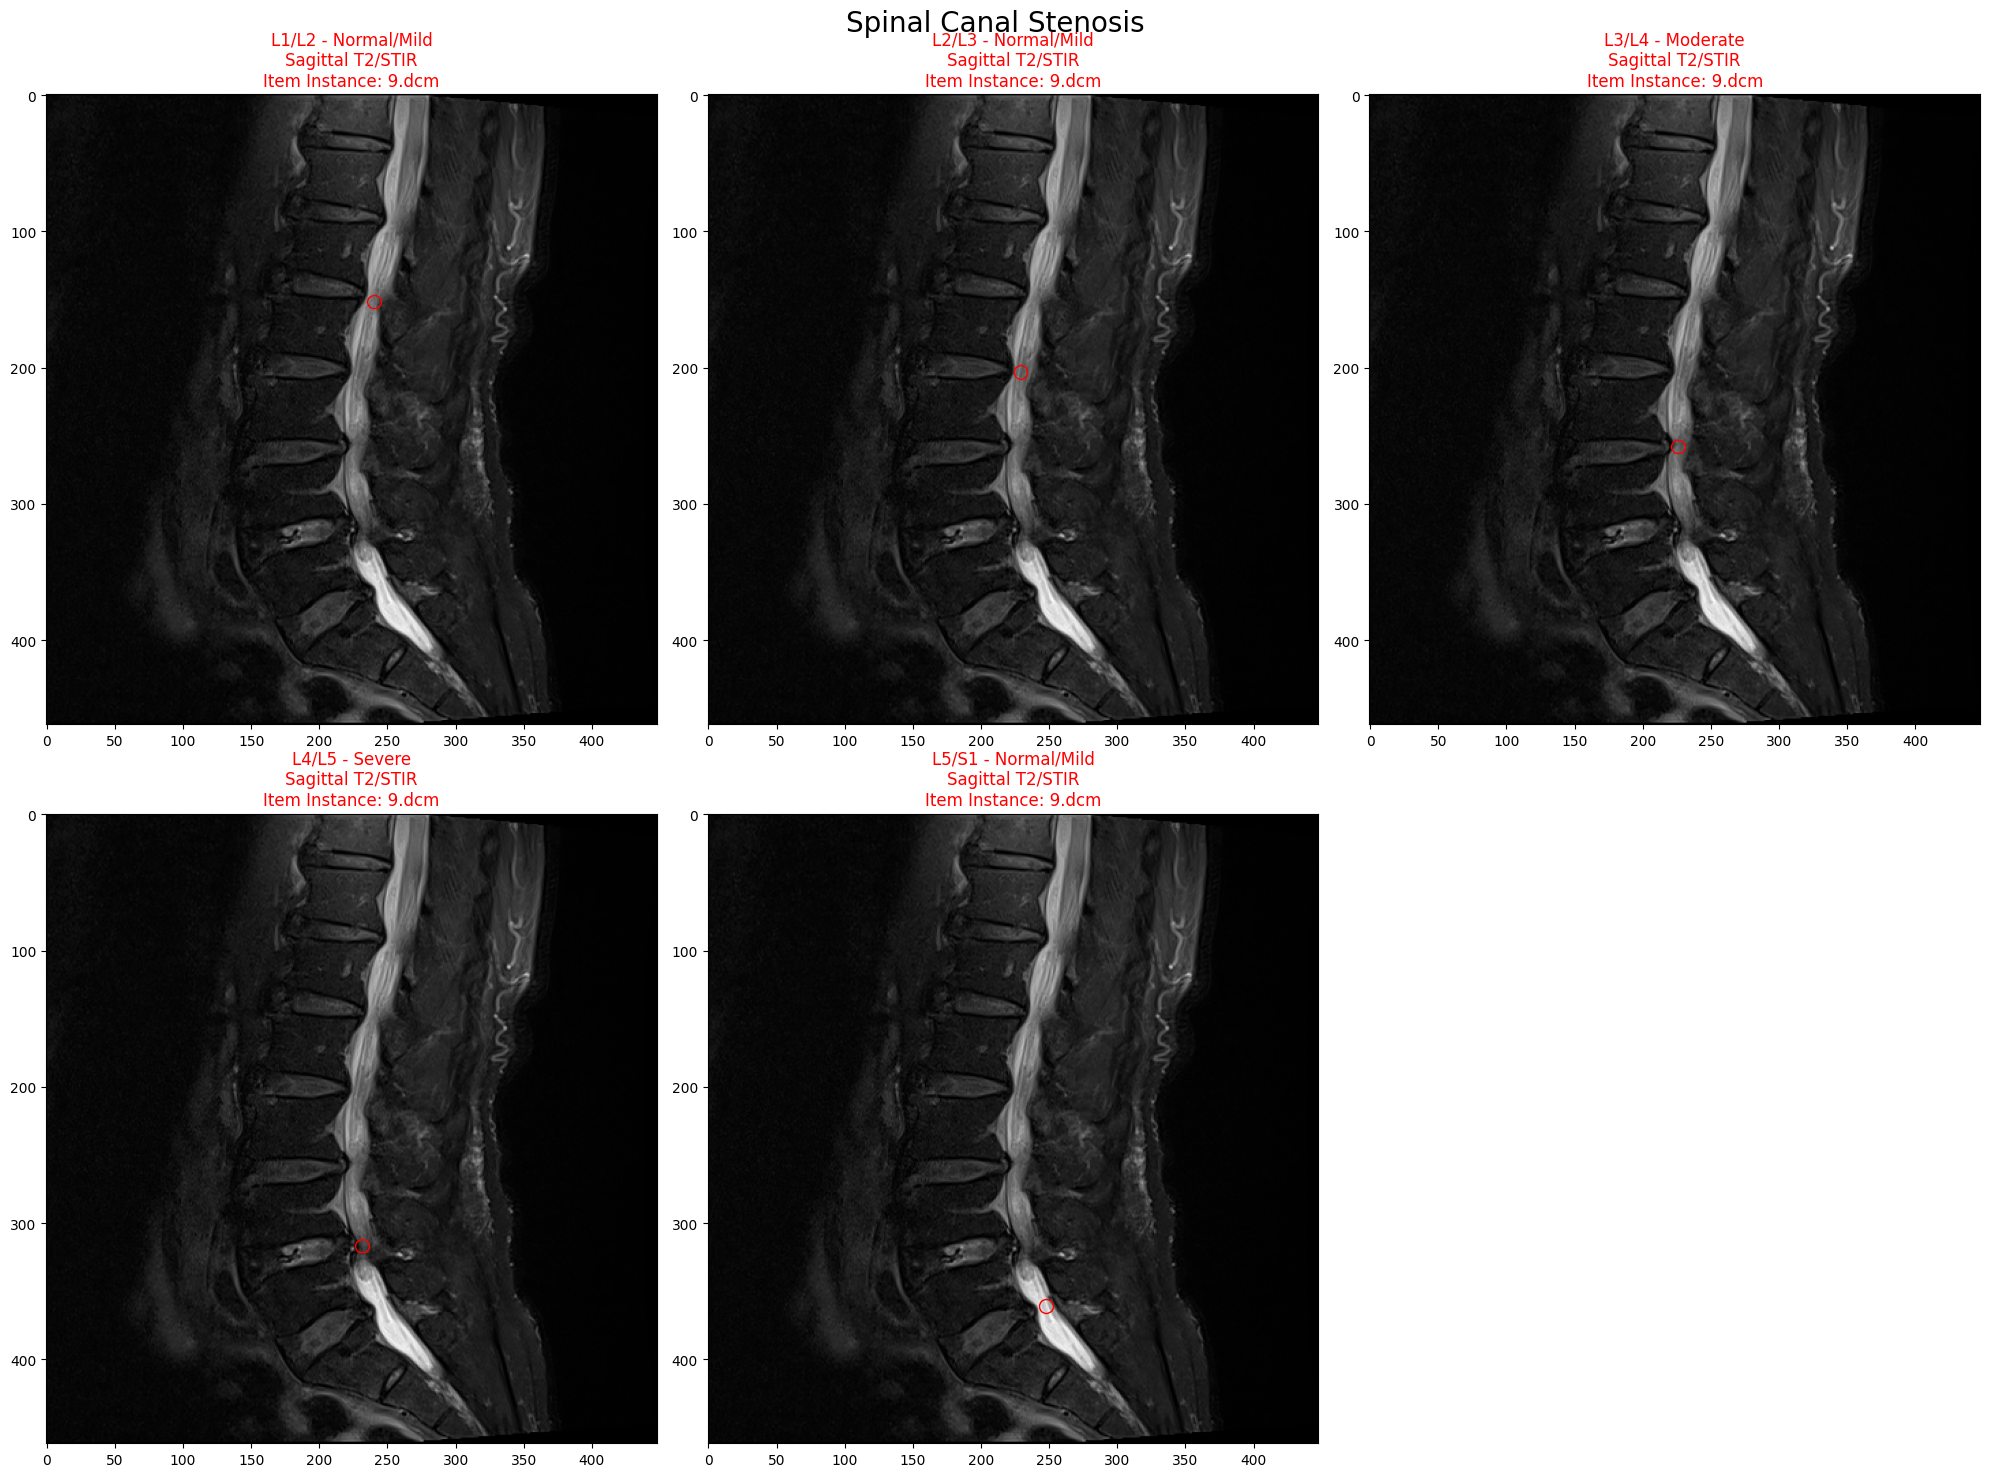

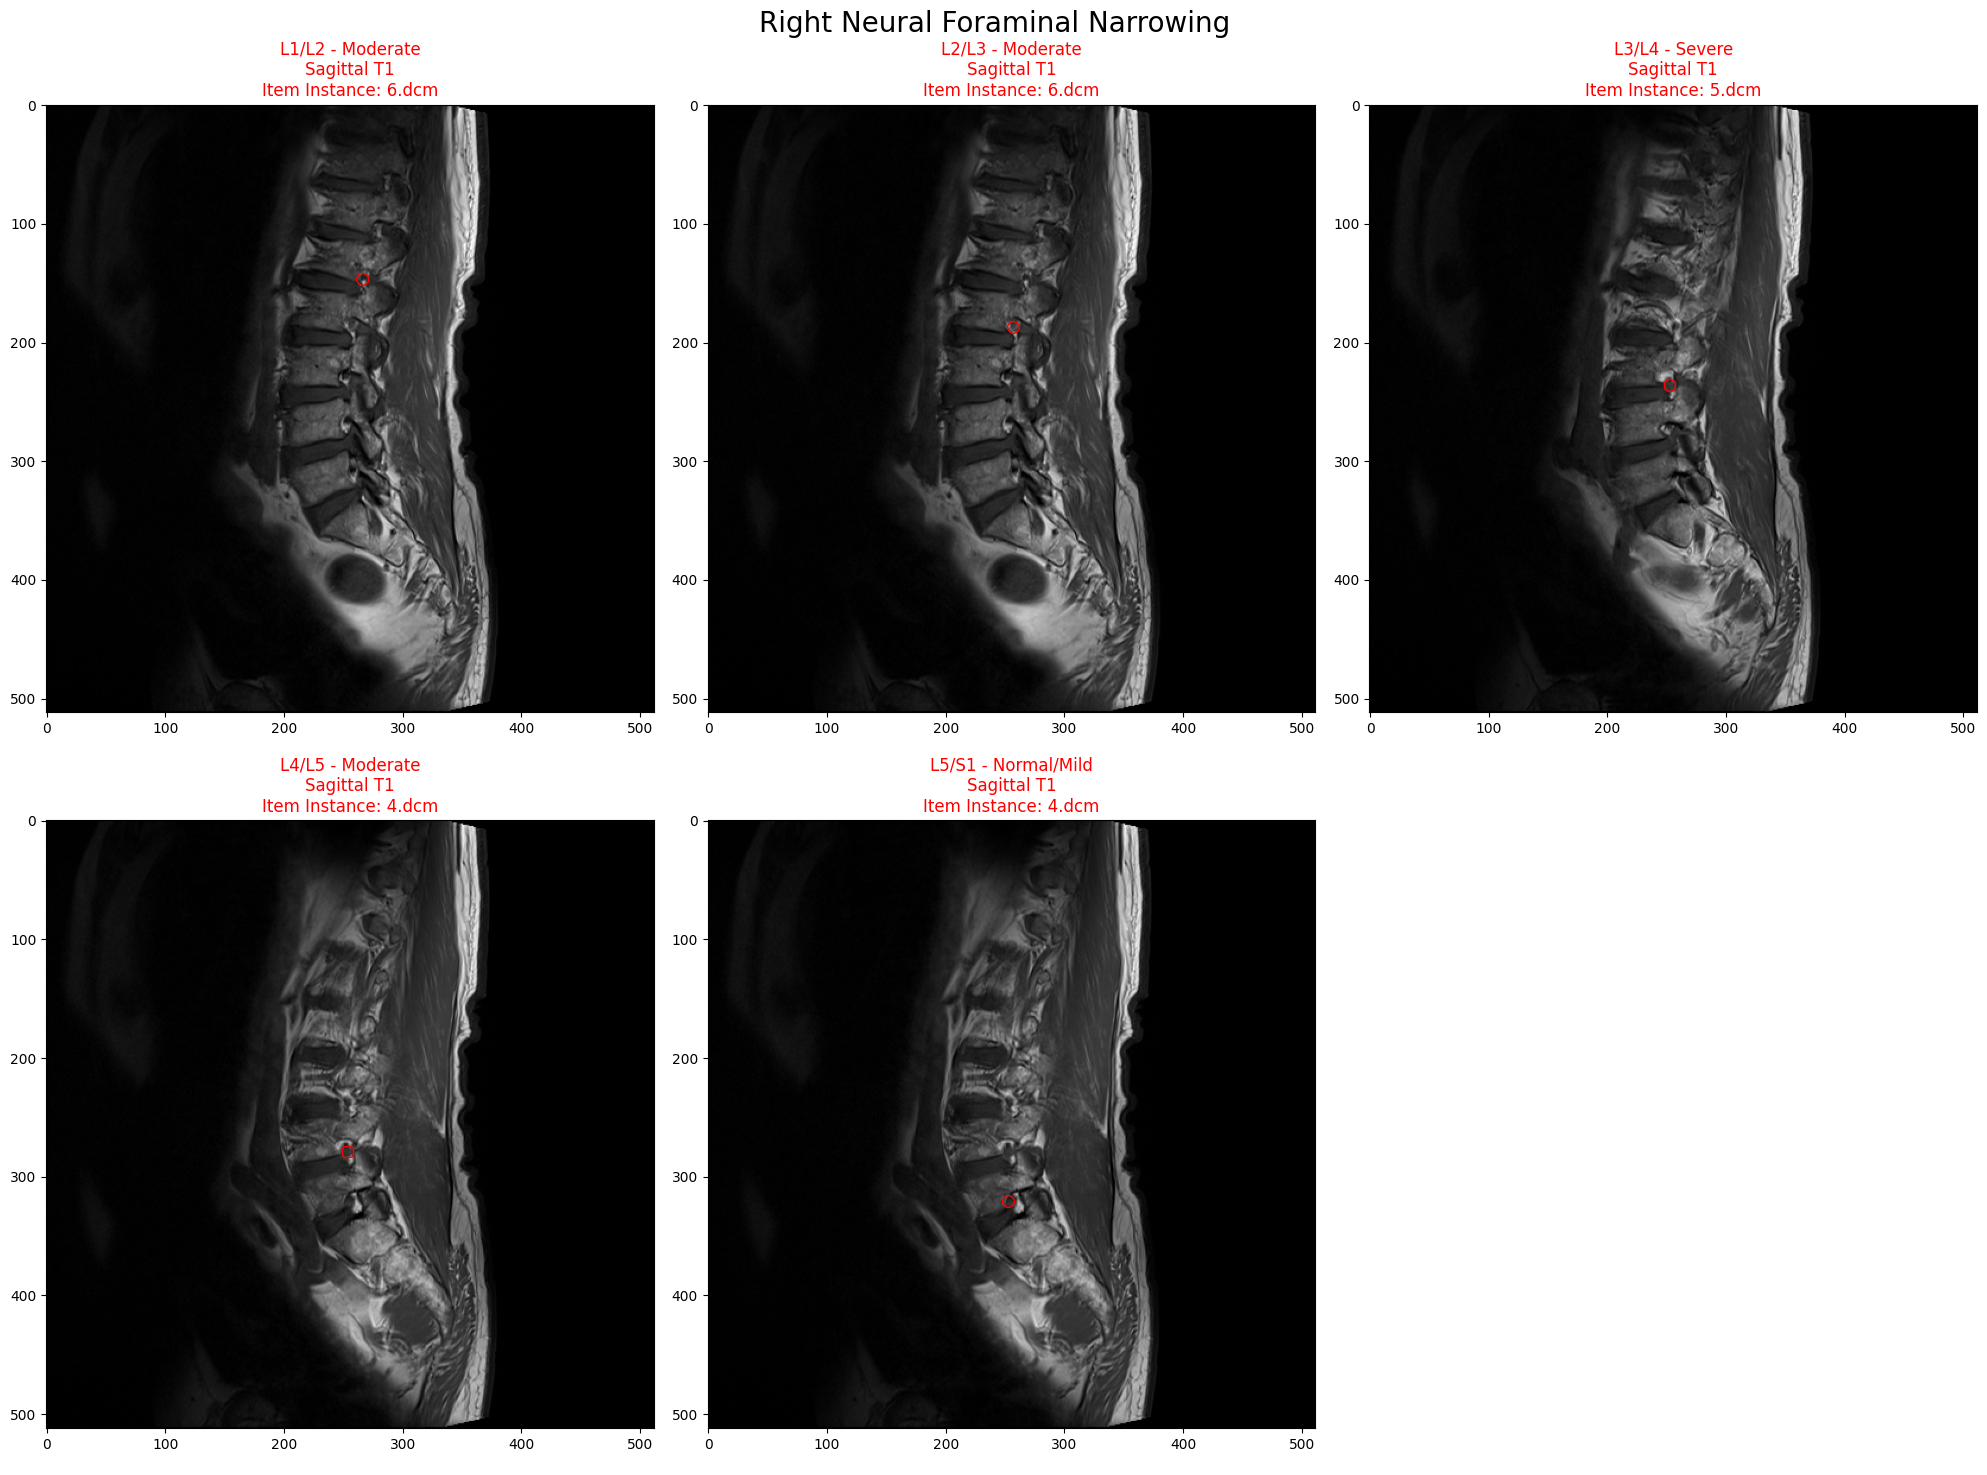

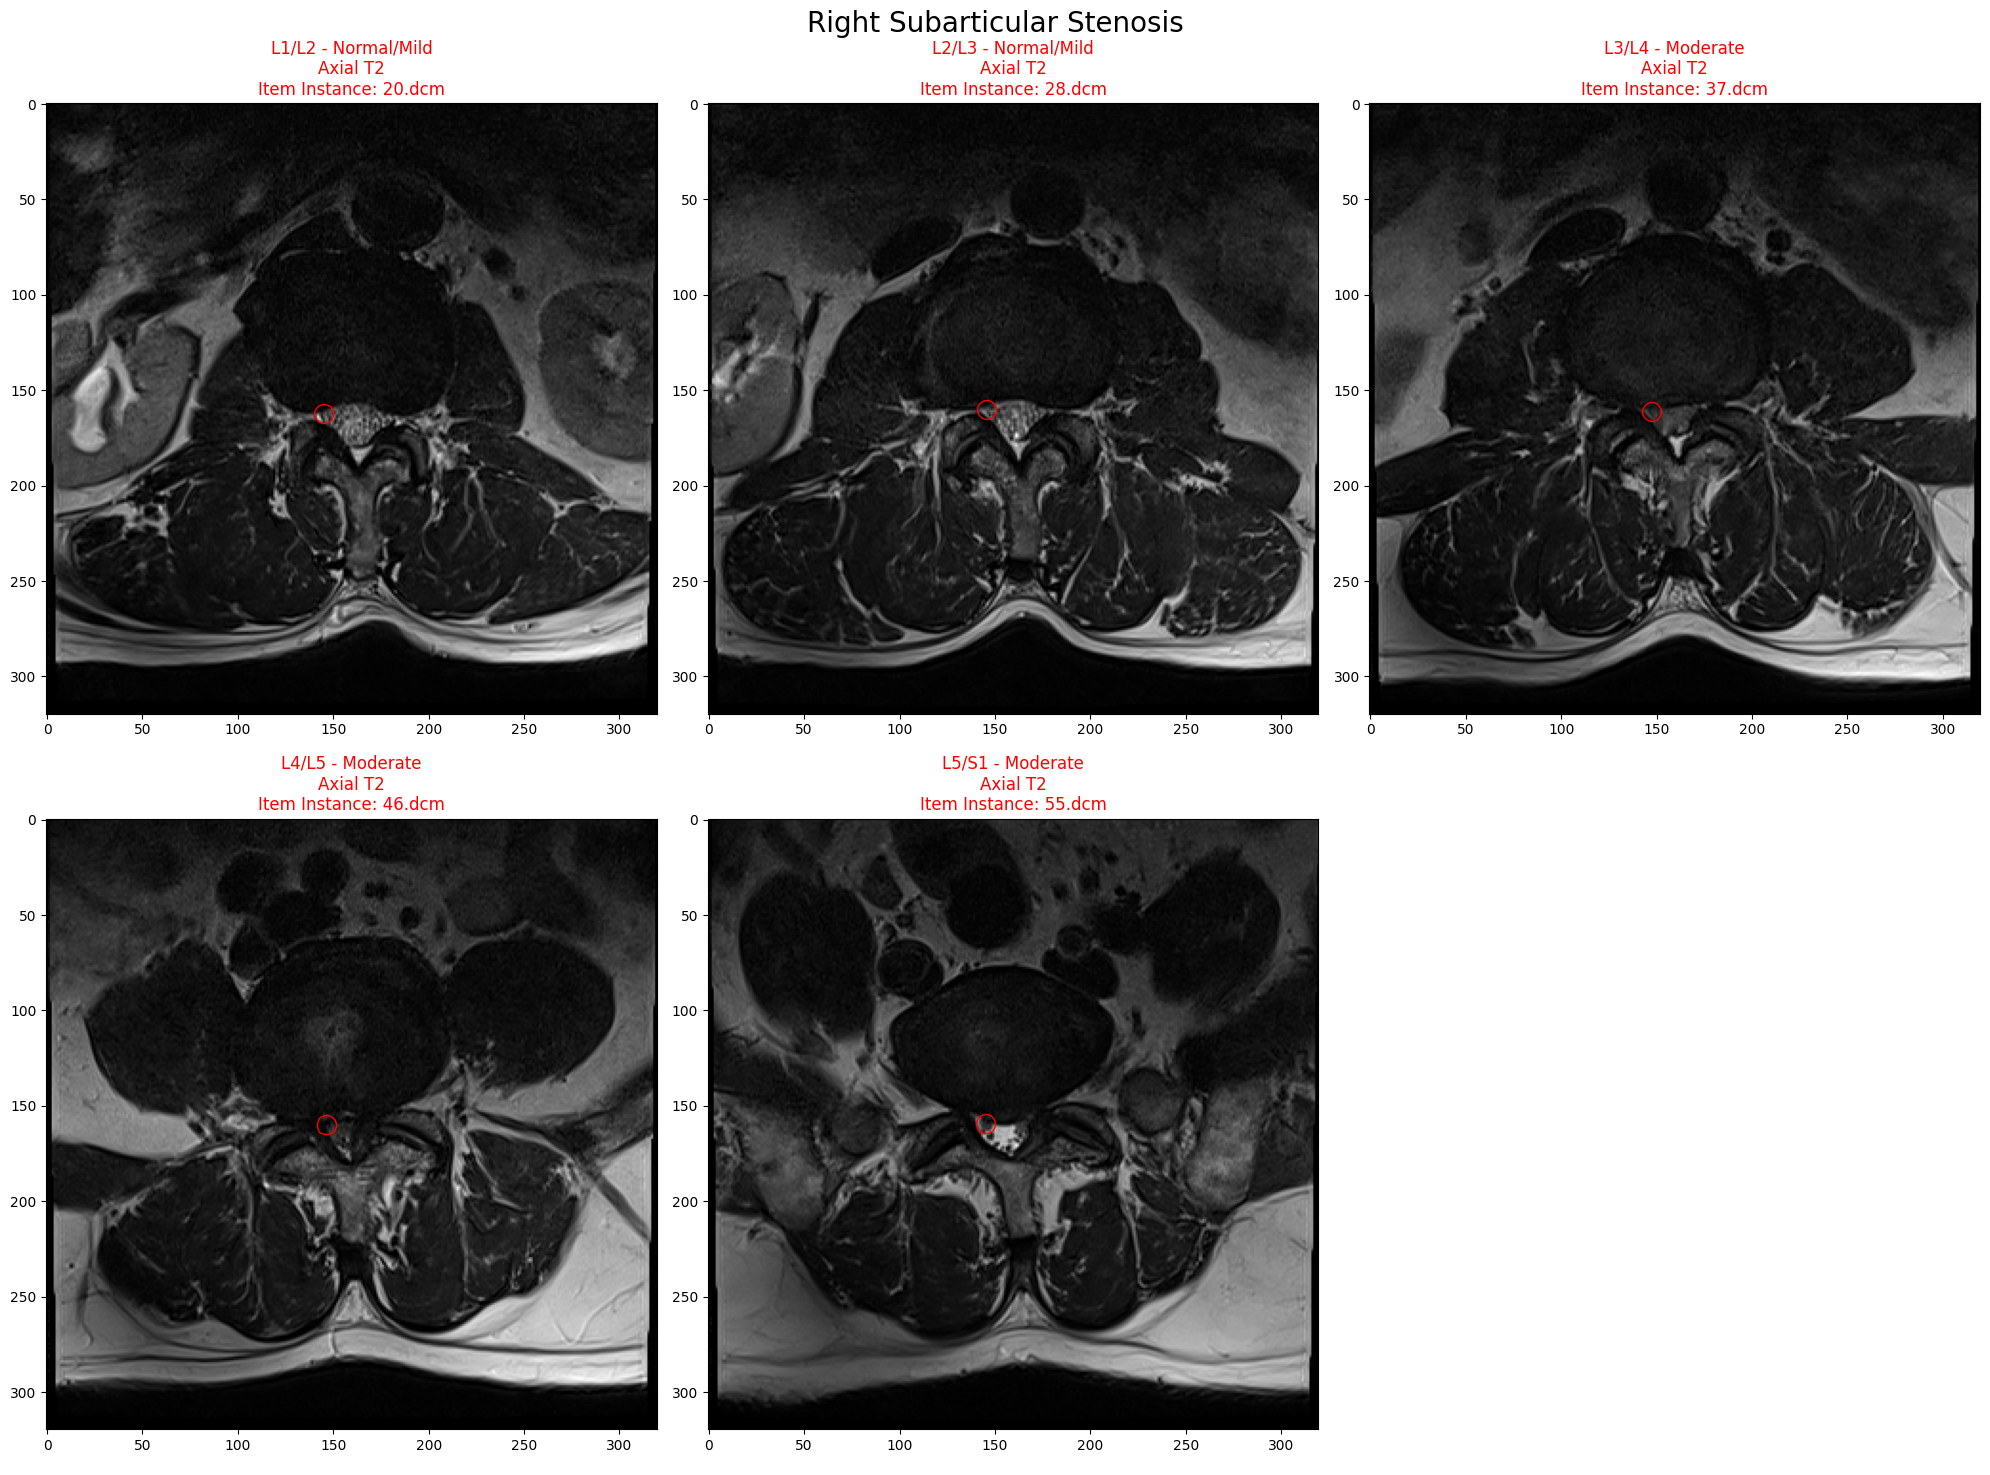

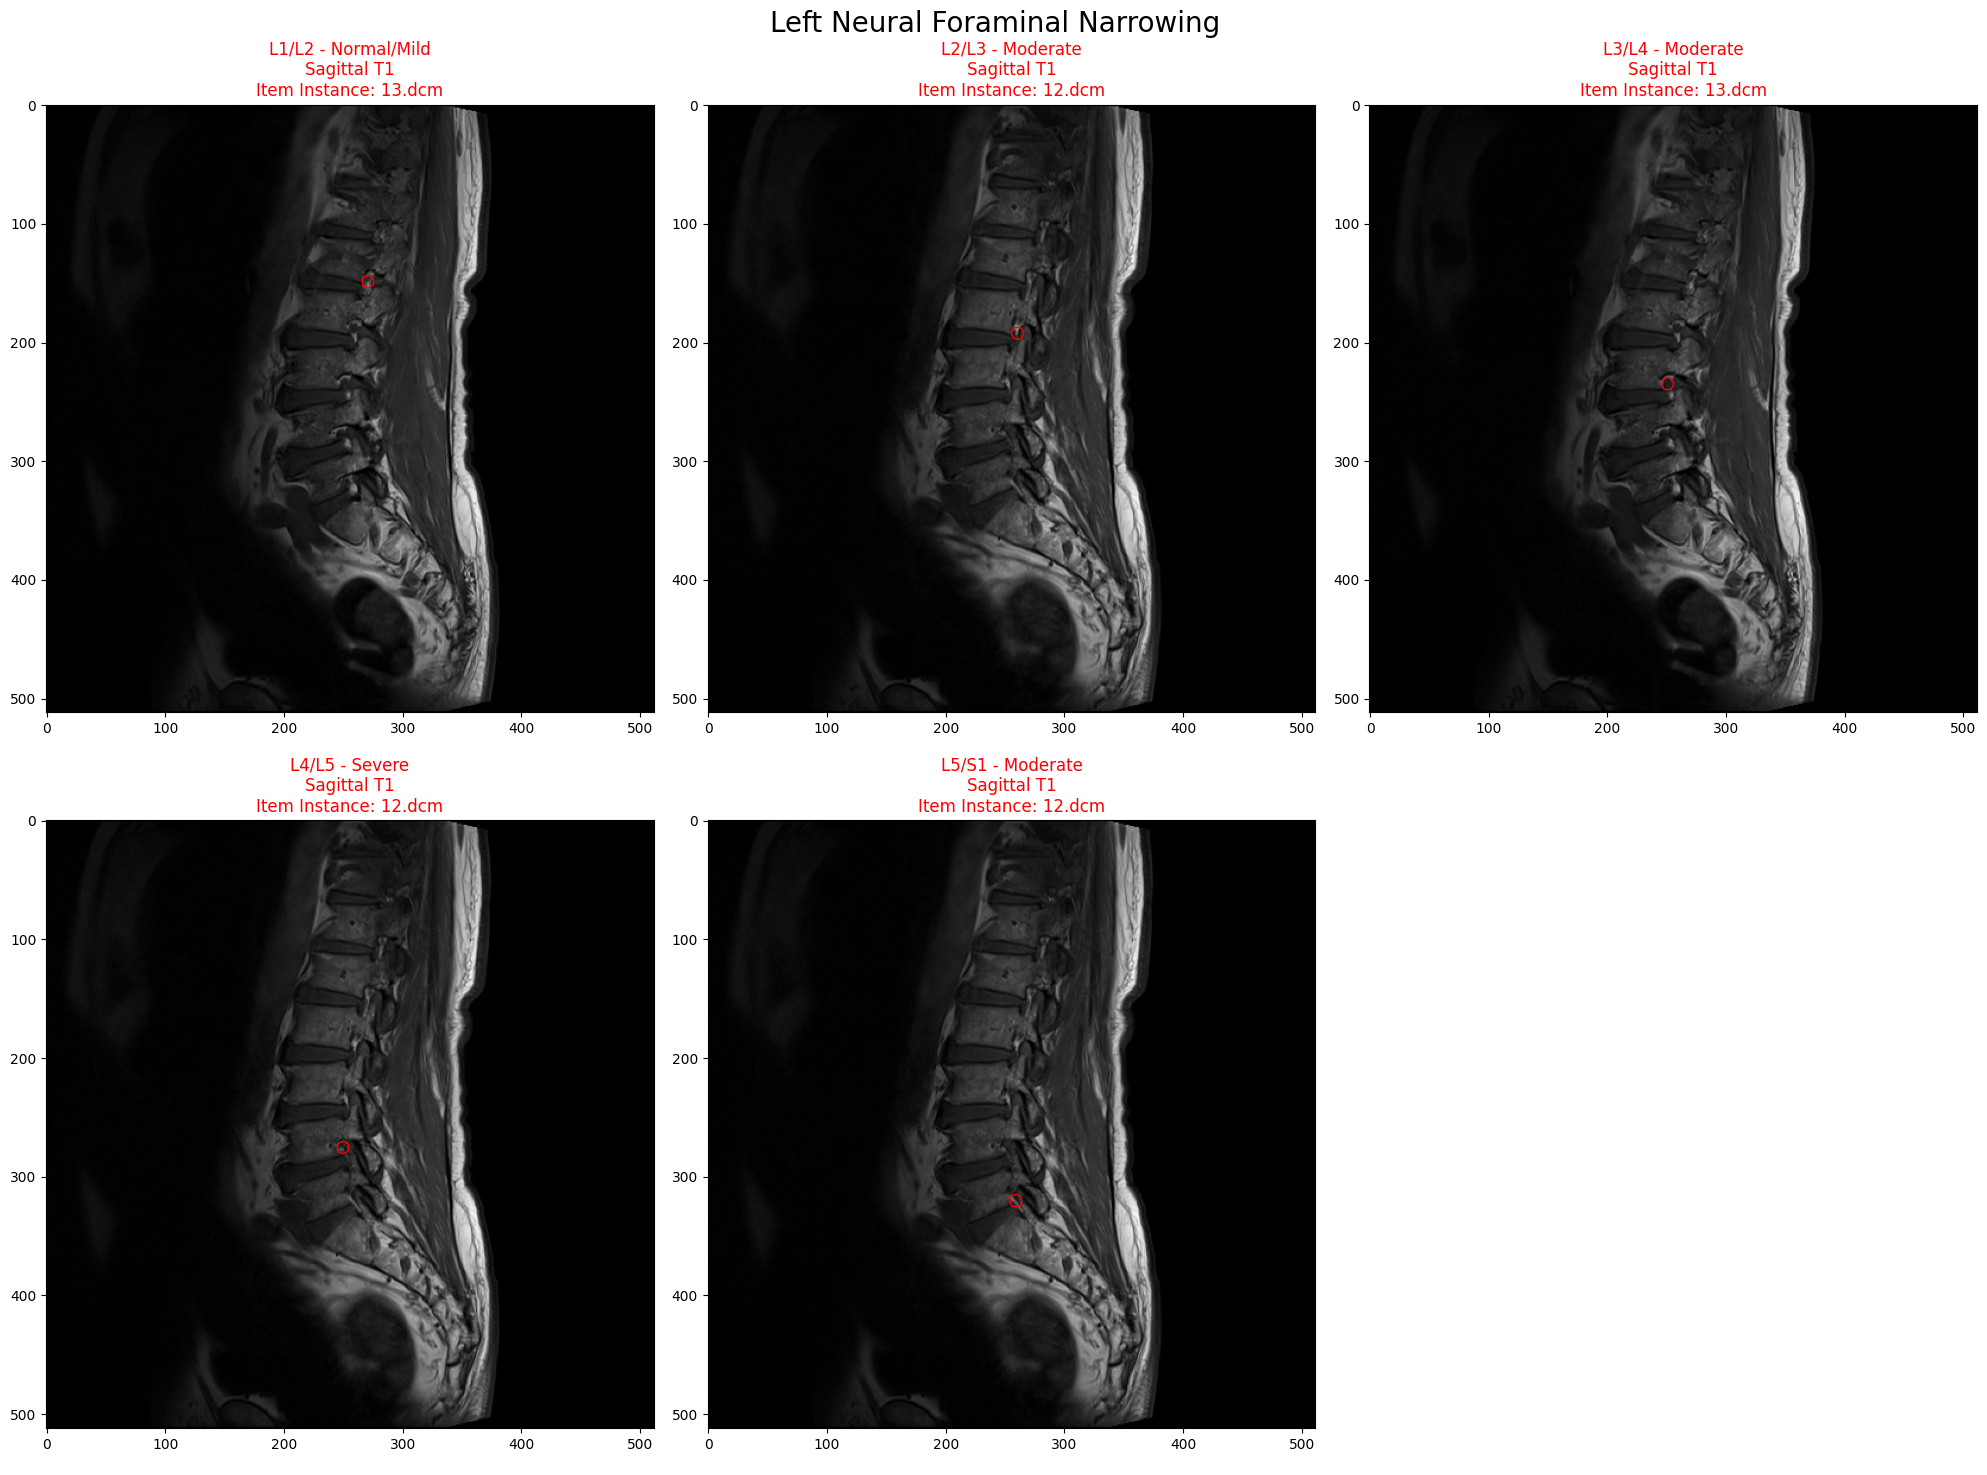

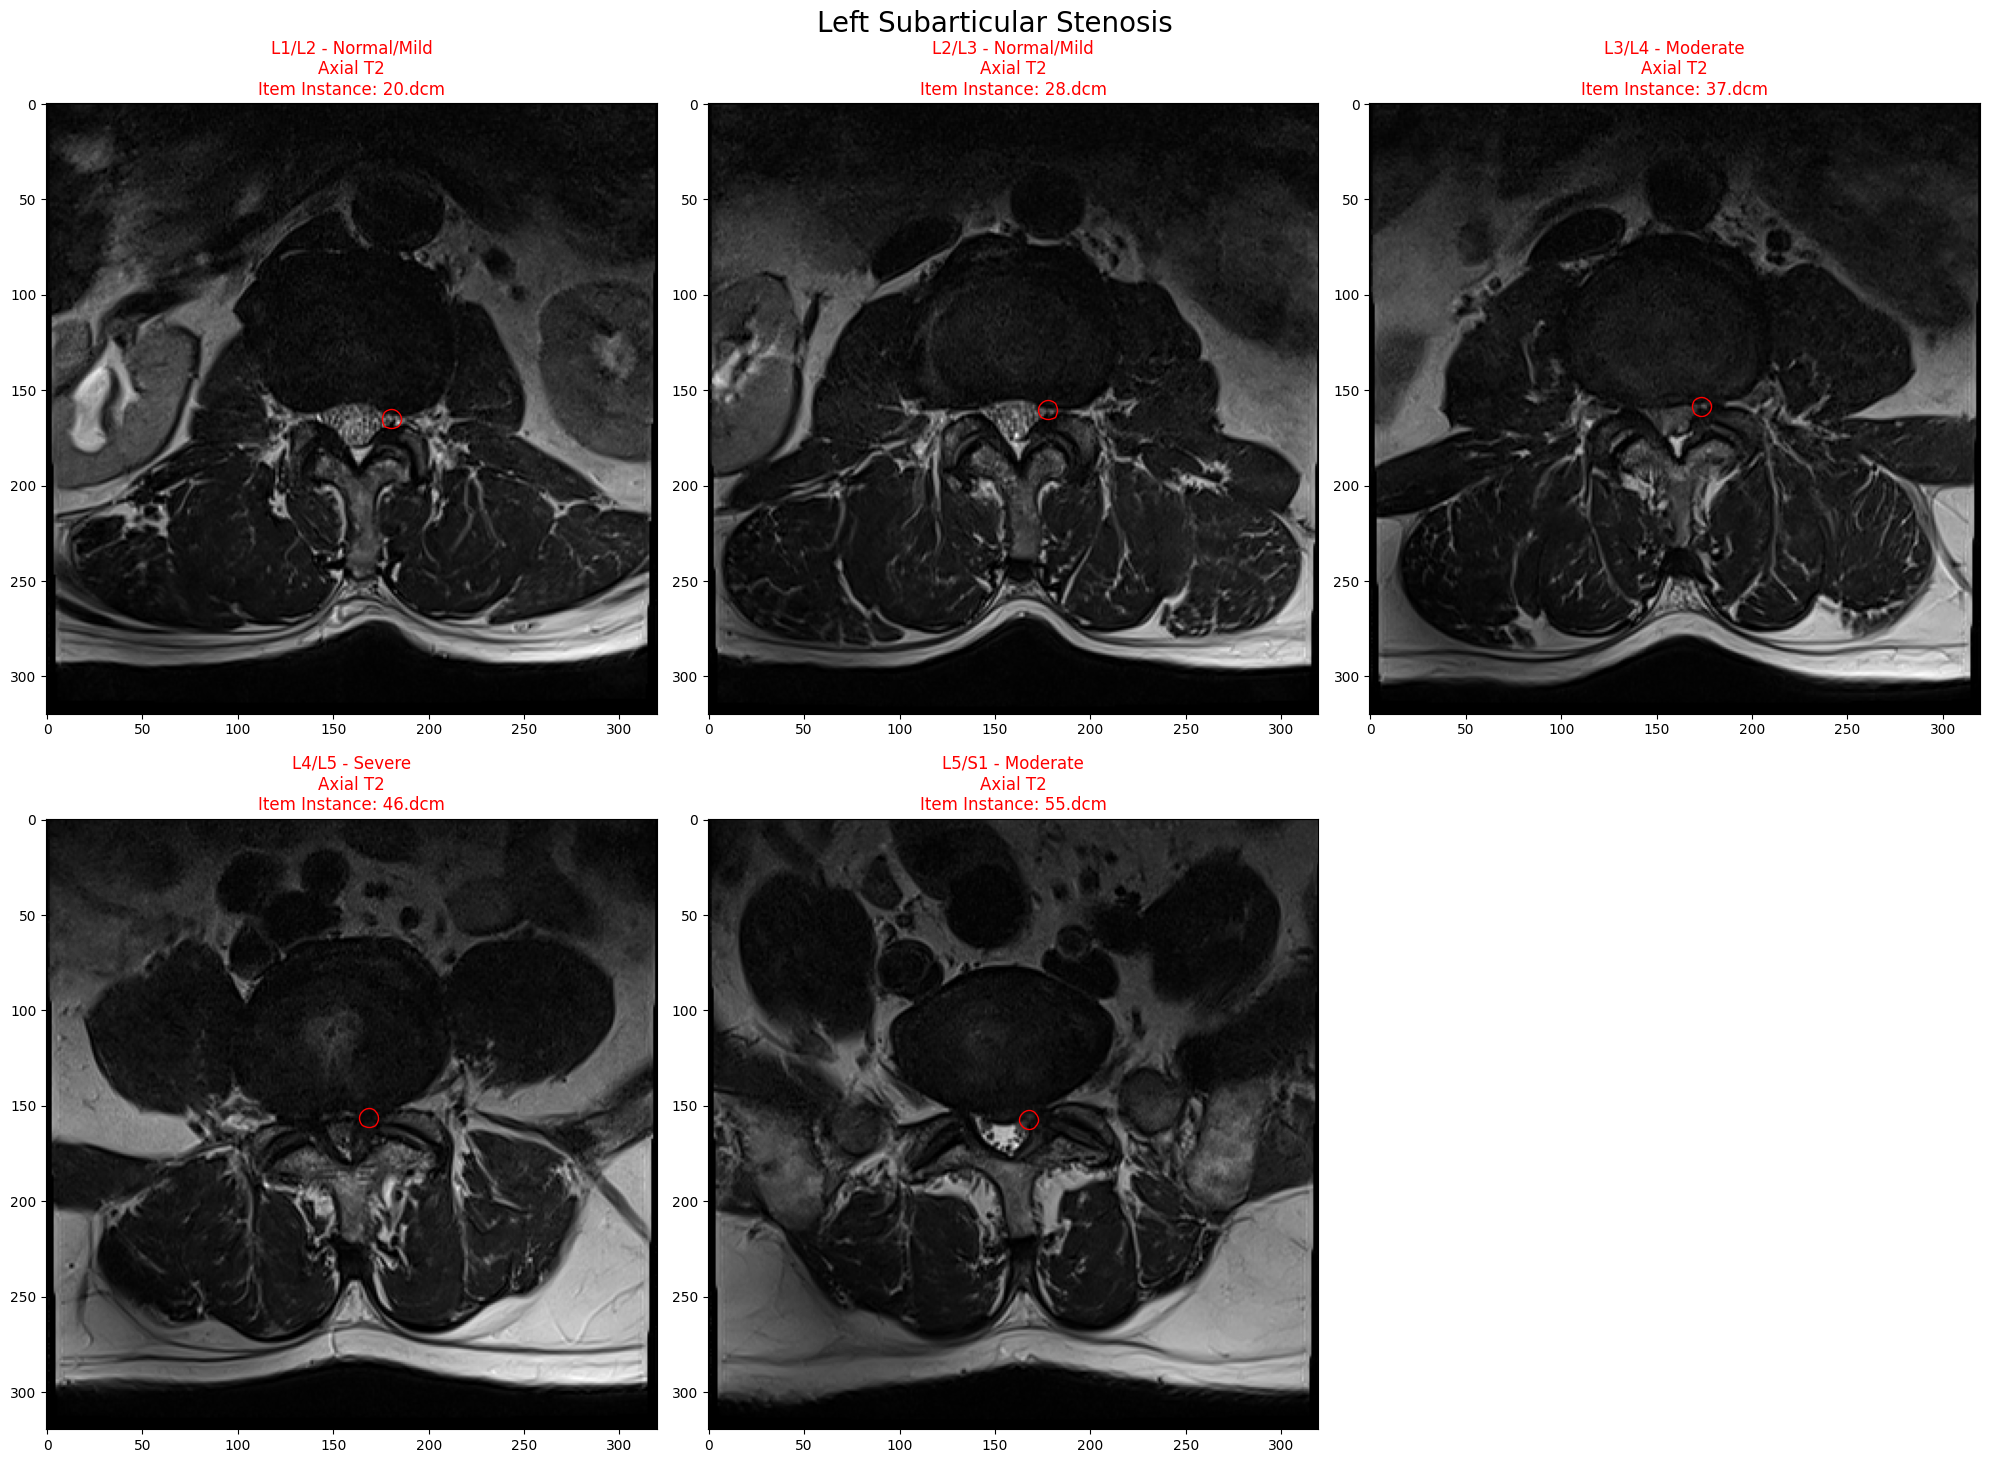

In [18]:
### CLASS BEGIN
class plot_utils:
    
    '''
    All Plotting utilities defined in this class under object name plotting.,
    '''
    
    def __init__(self, train_csv_df, train_label_df, train_series_desc_df, meta_obj_dict):
        self.train_csv_df = train_csv_df
        self.train_label_df = train_label_df
        self.train_series_desc_df = train_series_desc_df
        self.meta_obj = meta_obj_dict
        
    def plot_with_study_id(self, study_id: str, condition: str):
        '''
        param study_id : takes study_id as string
        param condition : condition to plot. 
        
        This method takes study_id and condition as arguments to plot all available instances of the scans corresponding to the study_id and condition.
        '''
        main_csv = self.train_csv_df
        
        to_plot_with: pl.DataFrame = self.train_label_df.filter((pl.col("study_id") == study_id) & (pl.col("condition") == condition)).sort(by=pl.col('level'))                               
        total_images = len(to_plot_with)
        images_per_row = 3
        total_rows = math.ceil(total_images/images_per_row)
        fig, axes = plt.subplots(total_rows, images_per_row, figsize = (20,15))
        # fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=4.0, wspace=0.4)
        # fig.tight_layout(h_pad=100, w_pad=100)
        
         ## find column in train_csv, split condition name and join with underscore, then append the vertebrae level
        severity = '_'.join(condition.lower().split(' ')) + '_'
        severity = self.train_csv_df.filter(pl.col('study_id') == sample_study_id).select(pl.selectors.starts_with(severity)).melt().sort(by='variable').select(pl.col('value').alias('severity'))
                                
        to_plot_with = to_plot_with.with_columns(severity) # add severity column to main df
        
        ## Plot scan Type
        desc_df = self.train_series_desc_df
        desc_df = desc_df.filter(pl.col('study_id') == study_id)
        
        if total_rows > 1: # flatten for easy looping
            axes = axes.flatten()
        else: # make it an iterable
            axes = [axes]  

        ### To plot as titles and subtitles - Vertebrae Level, Severity of Condition at each level

        for i in range(len(to_plot_with)):
            ax = axes[i] # easy looping here

            get_x = to_plot_with[i]['x'].item()
            get_y = to_plot_with[i]['y'].item()

            ref_id = to_plot_with[i]['series_id'].item()
            
            scan_description = desc_df.filter(pl.col('series_id') == ref_id).select(pl.col('series_description')).item()
            
            instance_number = to_plot_with[i]['instance_number'].item()
            instance = f'{instance_number}.dcm'

            level = str(to_plot_with[i]['level'].item() + ' - ' + to_plot_with[i]['severity'].item() + '\n' + scan_description + '\n' + f'Item Instance: {instance}')

            # read the img
            path_to_viz = os.path.join(self.meta_obj[study_id]['folder_path'], str(ref_id) , str(instance))
            ds = pydicom.dcmread(path_to_viz)
            #Convert to array
            arr = ds.pixel_array
            #Plot numpy array
            add_circle = Circle((get_x, get_y), 5, color='red', fill=False, snap=True)
            ax.add_patch(add_circle)
            # ax.plot(get_x, get_y, marker='x', color='red')
            ax.set_title(level, fontsize=12, color='red')
            ax.imshow(arr, cmap='gray')         

        for i in range(len(to_plot_with), len(axes)):
            axes[i].axis('off')

        plt.suptitle(condition, fontsize=20)
        plt.tight_layout()

### CLASS END

plotting = plot_utils(train_csv, train_label_coordinates, train_series_descriptions, meta_obj)
for i in range(len(conditions[0])):
        plotting.plot_with_study_id('100206310', conditions[0][i])

## Prepare Training DataFrame ##

In [19]:
train_series_descriptions

shape: (6_294, 3)
┌────────────┬────────────┬────────────────────┐
│ study_id   ┆ series_id  ┆ series_description │
│ ---        ┆ ---        ┆ ---                │
│ str        ┆ i64        ┆ str                │
╞════════════╪════════════╪════════════════════╡
│ 4003253    ┆ 702807833  ┆ Sagittal T2/STIR   │
│ 4003253    ┆ 1054713880 ┆ Sagittal T1        │
│ 4003253    ┆ 2448190387 ┆ Axial T2           │
│ 4646740    ┆ 3201256954 ┆ Axial T2           │
│ 4646740    ┆ 3486248476 ┆ Sagittal T1        │
│ …          ┆ …          ┆ …                  │
│ 4287160193 ┆ 1507070277 ┆ Sagittal T2/STIR   │
│ 4287160193 ┆ 1820446240 ┆ Axial T2           │
│ 4290709089 ┆ 3274612423 ┆ Sagittal T2/STIR   │
│ 4290709089 ┆ 3390218084 ┆ Axial T2           │
│ 4290709089 ┆ 4237840455 ┆ Sagittal T1        │
└────────────┴────────────┴────────────────────┘

In [20]:
### TODO: Join on series ID for different conditions, 

current_train_csv = train_series_descriptions.with_columns(
                                                        pl.all()
                                                    ).join(
                                                            train_label_coordinates, how="left", on=["series_id", "study_id"]
                                                          )

current_train_csv = current_train_csv.with_columns(
                                                        (
                                                            pl.col("condition").str.to_lowercase().str.split(" ").list.join("_") 
                                                            + "_" 
                                                            + pl.col("level").str.to_lowercase().str.split("/").list.join("_")

                                                         ).alias("condition_label")
                                                  )



/tmp/ipykernel_78/2130919465.py:3: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  current_train_csv = train_series_descriptions.with_columns(


In [21]:
current_train_csv

shape: (48_695, 9)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ study_id   ┆ series_id  ┆ series_des ┆ instance_ ┆ … ┆ level ┆ x         ┆ y         ┆ condition │
│ ---        ┆ ---        ┆ cription   ┆ number    ┆   ┆ ---   ┆ ---       ┆ ---       ┆ _label    │
│ str        ┆ i64        ┆ ---        ┆ ---       ┆   ┆ str   ┆ f64       ┆ f64       ┆ ---       │
│            ┆            ┆ str        ┆ i64       ┆   ┆       ┆           ┆           ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ 4003253    ┆ 702807833  ┆ Sagittal   ┆ 8         ┆ … ┆ L1/L2 ┆ 322.83185 ┆ 227.96460 ┆ spinal_ca │
│            ┆            ┆ T2/STIR    ┆           ┆   ┆       ┆ 8         ┆ 2         ┆ nal_steno │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ sis_l1_l2 │
│ 4003253    ┆ 702807833  ┆ Sagittal   ┆ 8         ┆ … ┆ L2/L3 ┆ 320.57142 ┆ 295.71428 ┆ spinal_ca │
│            ┆            ┆ T2/STIR    ┆           ┆   ┆       ┆ 9         ┆ 6         ┆ nal_steno │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ sis_l2_l3 │
│ 4003253    ┆ 702807833  ┆ Sagittal   ┆ 8         ┆ … ┆ L3/L4 ┆ 323.03030 ┆ 371.81818 ┆ spinal_ca │
│            ┆            ┆ T2/STIR    ┆           ┆   ┆       ┆ 3         ┆ 2         ┆ nal_steno │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ sis_l3_l4 │
│ 4003253    ┆ 702807833  ┆ Sagittal   ┆ 8         ┆ … ┆ L4/L5 ┆ 335.29203 ┆ 427.32743 ┆ spinal_ca │
│            ┆            ┆ T2/STIR    ┆           ┆   ┆       ┆ 5         ┆ 4         ┆ nal_steno │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ sis_l4_l5 │
│ 4003253    ┆ 702807833  ┆ Sagittal   ┆ 8         ┆ … ┆ L5/S1 ┆ 353.41592 ┆ 483.96460 ┆ spinal_ca │
│            ┆            ┆ T2/STIR    ┆           ┆   ┆       ┆ 9         ┆ 2         ┆ nal_steno │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ sis_l5_s1 │
│ …          ┆ …          ┆ …          ┆ …         ┆ … ┆ …     ┆ …         ┆ …         ┆ …         │
│ 4290709089 ┆ 4237840455 ┆ Sagittal   ┆ 11        ┆ … ┆ L1/L2 ┆ 219.46594 ┆ 97.831063 ┆ left_neur │
│            ┆            ┆ T1         ┆           ┆   ┆       ┆           ┆           ┆ al_forami │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ nal_narro │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ win…      │
│ 4290709089 ┆ 4237840455 ┆ Sagittal   ┆ 12        ┆ … ┆ L2/L3 ┆ 205.34059 ┆ 140.20708 ┆ left_neur │
│            ┆            ┆ T1         ┆           ┆   ┆       ┆ 9         ┆ 4         ┆ al_forami │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ nal_narro │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ win…      │
│ 4290709089 ┆ 4237840455 ┆ Sagittal   ┆ 12        ┆ … ┆ L3/L4 ┆ 202.72479 ┆ 181.01362 ┆ left_neur │
│            ┆            ┆ T1         ┆           ┆   ┆       ┆ 6         ┆ 4         ┆ al_forami │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ nal_narro │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ win…      │
│ 4290709089 ┆ 4237840455 ┆ Sagittal   ┆ 12        ┆ … ┆ L4/L5 ┆ 202.93333 ┆ 219.73333 ┆ left_neur │
│            ┆            ┆ T1         ┆           ┆   ┆       ┆ 3         ┆ 3         ┆ al_forami │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ nal_narro │
│            ┆            ┆            ┆           ┆   ┆       ┆           ┆           ┆ win…      │
│ 4290709089 ┆ 4237840455 ┆ Sagittal   ┆ 12        ┆ … ┆ L5/S1 ┆ 211.81395 ┆ 259.53488 ┆ left_neur │
│            ┆            ┆ T1         ┆  

In [22]:
train_df = train_csv.melt(id_vars=["study_id"], variable_name="condition_label", value_name="severity").join(current_train_csv, on=["study_id", "condition_label"], how="left").drop(["condition", "level"])


# If the Assertion doesn't pass the join is wrong. 


# First Assertion checks if there are value for each condition in the resulting join
assertion_agg = train_df.group_by("study_id").agg("condition_label").select("condition_label")
for record in assertion_agg["condition_label"]:
    assert(record.shape[0] == 25)
    

# second assertion checks where the melt performed to make the conditions in train.csv into rows was correct. 
# This reverses the melt and checks the value with the original dataframe (train.csv)
study_id_list = train_csv.select("study_id").to_series().to_list()
for study_id in study_id_list:
    list_1 = train_df.filter(pl.col("study_id") == study_id).drop(["x", "y", "instance_number", "series_id"]).select("severity").to_series().to_list()
    list_2 = train_csv.filter(pl.col("study_id") == study_id).drop("study_id").melt().select("value").to_series().to_list()
    assert(list_1 == list_2)

    
# If these assertions pass dataframe is ready for training



/tmp/ipykernel_78/4163407683.py:1: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  train_df = train_csv.melt(id_vars=["study_id"], variable_name="condition_label", value_name="severity").join(current_train_csv, on=["study_id", "condition_label"], how="left").drop(["condition", "level"])


In [27]:
train_df.filter(pl.col("study_id") == "100206310").group_by("series_id").agg(pl.col("series_description").unique())

shape: (3, 2)
┌────────────┬──────────────────────┐
│ series_id  ┆ series_description   │
│ ---        ┆ ---                  │
│ i64        ┆ list[str]            │
╞════════════╪══════════════════════╡
│ 1792451510 ┆ ["Sagittal T2/STIR"] │
│ 1012284084 ┆ ["Axial T2"]         │
│ 2092806862 ┆ ["Sagittal T1"]      │
└────────────┴──────────────────────┘